* This notebook experiments with new NestedAE architectures.
* Features that are useful are then pushed to the source code.

In [1]:
import math
import random
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import kstest, ks_2samp
import torch
from torch.nn import Module, ModuleList, ModuleDict, Linear, L1Loss
from torch.utils.data import DataLoader
from torch.optim import SGD
import pandas as pd
import seaborn as sns

import umap

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf, optimize_acqf_discrete

from shap.explainers import Exact
import shap

from NestedAE.nn_utils import check_dict_key_exists, set_layer_init

/Users/nikhilthota/miniconda3/envs/NestedAE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### AE model

In [5]:
class AE(Module):
    def __init__(self, module_params):
        super(AE, self).__init__()
        ae_modules = {}
        # Outer loop iterates over the ae_modules
        for module_name, module_dict in module_params['modules'].items():
            layer_list = ModuleList()
            # Check for existence of keys or take defualts if not present
            if check_dict_key_exists('hidden_layers', module_dict):
                hidden_layers = module_dict['hidden_layers']
            else:
                hidden_layers = 0
            if check_dict_key_exists('hidden_dim', module_dict):
                hidden_dim = module_dict['hidden_dim']
            else:
                hidden_dim = None
            if check_dict_key_exists('hidden_activation', module_dict):
                hidden_activation = module_dict['hidden_activation']
            else:
                hidden_activation = None
            if check_dict_key_exists('output_activation', module_dict):
                output_activation = module_dict['output_activation']
            else:
                output_activation = None
            if check_dict_key_exists('layer_dropout', module_dict):
                layer_dropout = module_dict['layer_dropout']
            else:
                layer_dropout = None
            if check_dict_key_exists('layer_kernel_init', module_dict):
                layer_kernel_init = module_dict['layer_kernel_init']
            else:
                layer_kernel_init = None
            if check_dict_key_exists('layer_bias_init', module_dict):
                layer_bias_init = module_dict['layer_bias_init']
            else:
                layer_bias_init = None
            if check_dict_key_exists('load_params', module_dict):
                load_params = module_dict['load_params']
            else:
                load_params = False

            num_layers = hidden_layers + 1
            for layer_num in range(num_layers):
                if layer_num == 0:
                    # Calculate the input dimensions to first layer
                    input_dim = module_dict['input_dim']

                    if hidden_dim is not None:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                    else:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                        if output_activation:
                            layer_list.append(output_activation)
                        break # Only output layer
                elif layer_num == num_layers - 1:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                    if output_activation:
                        layer_list.append(output_activation)
                    break # Dont add hidden activations
                else:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                # Add hidden activations if specified
                if hidden_activation:
                    layer_list.append(hidden_activation)
                if layer_dropout:
                    layer_list.append(layer_dropout)
            # Initialize weights for all layers
            if layer_kernel_init:
                layer_list = set_layer_init(layer_list, module_dict, init='kernel')
            if layer_bias_init:
                layer_list = set_layer_init(layer_list, module_dict, init='bias')

            # Finally add to ae_module list
            ae_modules[module_name] = layer_list
        self.ae_modules = ModuleDict(ae_modules)

    def forward(self, x):
        """Forward pass through the model."""
        # Stores all module outputs
        ae_module_outputs = {}

        # Pass through encoder
        for j, layer in enumerate(self.ae_modules['encoder']):
            if j == 0:
                ae_module_outputs['z'] = layer(x)
            else:
                ae_module_outputs['z'] = layer(ae_module_outputs['z'])

        # Pass through predictor
        for j, layer in enumerate(self.ae_modules['y1_predictor']):
            if j == 0:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['y1_pred'])

        # Pass through predictor
        for j, layer in enumerate(self.ae_modules['latent_predictor']):
            if j == 0:
                ae_module_outputs['latent_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['latent_pred'] = layer(ae_module_outputs['latent_pred'])

        for j, layer in enumerate(self.ae_modules['decoder']):
            if j == 0:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['x_pred'])

        return ae_module_outputs

#### Datasets Details

In [8]:
# from BorutaShap import BorutaShap
# import pandas as pd
# import numpy as np

# ---------------------------------------------------------
dataset_loc = 'datasets/synthetic_dataset/synthetic_dataset3.csv'

#########################################
# FOR ABX3 BANDGAP DATASET 
#########################################

latent_col_names = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5']

# # Scale 1 descriptors
# descriptors = ['z1',
#                'z2',
#                'f1',
#                'f2',
#                'f3',
#                'f4']
# target = ['y1']

descriptors = ['z3',
                'z4',
                'z5',
                'z6',
                'f5',
                'f6',
                'f7',
                'f8']
target = ['y2']

# descriptors = descriptors1 + descriptors2

standardize_descs = True

split_strategy = 'kfold' 
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_split = 0.9
# For combined dataset
# defined_qs = [0.2, 0.4, 0.6, 0.8]
# For dataset 1
# defined_qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# For dataset 2
# defined_qs = [0.2, 0.4, 0.6, 0.8]

random_state = 42

plot_train_test_dist = False

plot_pcc_matrix = False

model_save_dir = 'nestedae_ae2_synthetic_dataset'
# ---------------------------------------------------------

X_dataframe = pd.read_csv(dataset_loc)[descriptors + latent_col_names]
Y_dataframe = pd.read_csv(dataset_loc)[target]

if standardize_descs:
    desc_means = []
    desc_std_devs = []
    for desc in X_dataframe.columns.tolist():
        mean = X_dataframe[desc].mean()
        desc_means.append(mean)
        std_dev = X_dataframe[desc].std()
        desc_std_devs.append(std_dev)
        X_dataframe[desc] = (X_dataframe[desc] - mean) / std_dev
    print('Descriptors standardized.')
else:
    print('Descriptors not standardized.')

print(f'Dataframe Statistics : {X_dataframe.describe()}')

print(f'Dataset columns : \n')
print(X_dataframe.columns)
dataset = np.concatenate((X_dataframe.to_numpy(dtype=np.float32), 
                          Y_dataframe[target].to_numpy(dtype=np.float32)), axis=1)
print(dataset.shape)

Descriptors standardized.
Dataframe Statistics :                  z3            z4            z5            z6            f5  \
count  2.000000e+02  2.000000e+02  2.000000e+02  2.000000e+02  2.000000e+02   
mean   1.110223e-18  3.108624e-17  8.881784e-18  1.776357e-17 -8.437695e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.765064e+00 -1.728875e+00 -1.842306e+00 -1.713564e+00 -1.433835e+00   
25%   -8.787522e-01 -7.955121e-01 -8.205032e-01 -8.431905e-01 -7.252115e-01   
50%   -9.818946e-03 -4.164233e-02  1.202756e-01  2.718310e-02 -3.395227e-01   
75%    8.287016e-01  8.244105e-01  7.594651e-01  8.118056e-01  5.304792e-01   
max    1.710669e+00  1.807134e+00  1.722751e+00  1.716480e+00  3.668194e+00   

                 f6            f7            f8            l0            l1  \
count  2.000000e+02  2.000000e+02  2.000000e+02  2.000000e+02  2.000000e+02   
mean   1.776357e-17  1.776357e-17 -8.881784e-18  2.664535e-17  4.440892e-18   
st

### Compare with other models

In [ ]:
x = X_dataframe.to_numpy(dtype=np.float32)
y = Y_dataframe[target].to_numpy(dtype=np.float32)

print(f'The quantiles : {np.quantile(y, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}')
y_binned = np.digitize(y, np.quantile(y, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
# kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
split_idxs_all_folds = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y_binned)):
# for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
    split_idxs_all_folds.append((train_idx, val_idx))
    ks_stat, p_value = ks_2samp(y[train_idx], y[val_idx])
    print(f'Fold {fold} : KS statistic = {ks_stat}, p-value = {p_value}')

from xgboost import XGBRegressor

param_grid_xgb = {
        'n_estimators': [250, 500, 1000, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        # 'colsample_bytree': [0.6, 0.8, 1.0],
        # 'alpha': [0, 0.01, 0.1],
        # 'lambda':[0, 0.01, 0.1]
    }
param_grid_RF = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [2, 3, 4, 5, 10],
    'ccp_alpha': [0.0, 0.01, 0.1]
}
param_grid_nusvr = {
    'nu': [0.25, 0.5, 0.75],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],  # Only relevant for 'poly' kernel
    'coef0': [0.0, 0.1, 0.5],  # Only relevant for 'poly' and 'sigmoid' kernels
    'C': [0.5, 1, 5, 10, 50, 100]
}
param_grid_lasso = {
        'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]
}
param_grid_ridge = {
          'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]
}

grid = GridSearchCV(estimator=XGBRegressor(random_state=random_state),
                    param_grid=param_grid_xgb,
                    scoring='neg_mean_absolute_error', 
                    cv=split_idxs_all_folds, # If using None defaults to 5 fold cross-validation
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True)
grid.fit(x, y.squeeze())
print(f'Best parameters found: {grid.best_params_}') # Parameter setting that gave best performance on hold out data
print(f'Best Cross validated score of the best estimator found: {-grid.best_score_}') # Mean cross-validated score of the best_estimator
# Get the mean absolute error on the training set across all folds for best model
print(f"Mean test score of the best estimator across all folds : {grid.cv_results_['mean_test_score'][grid.best_index_]}")
print(f"Std of test score of the best estimator across all folds : {grid.cv_results_['std_test_score'][grid.best_index_]}")
print(f"Mean train score of the best estimator across all folds : {grid.cv_results_['mean_train_score'][grid.best_index_]}")
print(f"Std of train score of the best estimator across all folds : {grid.cv_results_['std_train_score'][grid.best_index_]}")

# Find the indices of top 10 test scores
top_10_indices = sorted(range(len(grid.cv_results_['mean_test_score'])), key=lambda i: grid.cv_results_['mean_test_score'][i], reverse=True)[:10]
# Get the top 10 parameter sets
print("Top 10 parameter sets:")
for idx in top_10_indices:
    print(f"Params: {grid.cv_results_['params'][idx]}, Mean Test Score: {grid.cv_results_['mean_test_score'][idx]}, Std Test Score: {grid.cv_results_['std_test_score'][idx]}")

In [ ]:
# https://github.com/Ekeany/Boruta-Shap -> Change to boruta_shap conda env

# use boruta_shap env and import these libraries in the top cell 
# from BorutaShap import BorutaShap
# import pandas as pd
# import numpy as np

feature_selector = BorutaShap(importance_measure='shap', classification=False)
feature_selector.fit(X=pd.DataFrame(dataset[:, :(len(latent_col_names + descriptors))], columns=latent_col_names + descriptors),
                     y=dataset[:, 15].reshape(-1, 1), 
                     n_trials=100,
                     sample=False,
                     train_or_test='train',
                     random_state=random_state,
                     normalize=True,
                     verbose=True) # importance values normaized accdg to Z score
feature_selector.plot(which_features='all', y_scale=None) # Convert to log by y_scale='log'

In [ ]:
data = feature_selector.history_x.iloc[1:]
data['index'] = data.index
data = pd.melt(data, id_vars='index', var_name='Methods')

decision_mapper = feature_selector.create_mapping_of_features_to_attribute(maps=['Tentative','Rejected','Accepted', 'Shadow'])
data['Decision'] = data['Methods'].map(decision_mapper)
data.drop(['index'], axis=1, inplace=True)

options = { 'accepted' : feature_selector.filter_data(data,'Decision', 'Accepted'),
            'tentative': feature_selector.filter_data(data,'Decision', 'Tentative'),
            'rejected' : feature_selector.filter_data(data,'Decision', 'Rejected'),
            'all' : data}
print(data)

# Save data to csv file
data.to_csv('data.csv', index=False)


#### Data Distribution Analysis

In [9]:
train_idxs = []
val_idxs = []
if split_strategy == 'kfold':
    kf = KFold(n_splits=int(1/(1 - train_split)), shuffle=True, random_state=random_state)
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_idxs.append(train_idx)
        val_idxs.append(val_idx)
        y1 = Y_dataframe[target].to_numpy(dtype=np.float32)
        ks_stat, p_val = ks_2samp(y1[train_idxs[-1]], y1[val_idxs[-1]])
        print(f'Fold {fold} ks-stat for target: {np.round(ks_stat, 3)}, p-value: {np.round(p_val, 3)}')
elif split_strategy == 'strat_kfold':
    print('Using a stratified k fold split strategy.')
    y = Y_dataframe[target].to_numpy(dtype=np.float32)
    skf = StratifiedKFold(n_splits=int(1/(1 - train_split)), shuffle=True, random_state=random_state)
    y_binned = np.digitize(y, np.quantile(y, defined_qs))
    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, y_binned)):
        train_idxs.append(train_idx)
        val_idxs.append(val_idx)
        ks_stat, p_val = ks_2samp(y[train_idx], y[val_idx])
        print(f'Fold {fold} ks-stat for target: {np.round(ks_stat, 3)}, p-value: {np.round(p_val, 3)}')
elif split_strategy == 'random':    
    # Train - Test split of indices
    idxs = list(range(X_dataframe.shape[0]))
    for seed in seeds:
        rng = np.random.default_rng(seed=seed)
        rng.shuffle(idxs)
        # print(idxs)
        train_idxs.append(idxs[:int(train_split*len(idxs))])
        val_idxs.append(idxs[int(train_split*len(idxs)):])
        y1 = Y_dataframe[target].to_numpy(dtype=np.float32)
        ks_stat, p_val = ks_2samp(y1[train_idxs[-1]], y1[val_idxs[-1]])
        print(f'Seed {seed} ks-stat for target: {np.round(ks_stat, 3)}, p-value: {np.round(p_val, 3)}')
else:
    raise ValueError(f'Unknown split strategy: {split_strategy}')

# for_fold = 5
# # Check how do the histograms of train and test distribution match up
# if plot_train_test_dist:
#     X_dataframe_train = X_dataframe.iloc[train_idxs[for_fold]]
#     Y_dataframe_train = Y_dataframe.iloc[train_idxs[for_fold]]
#     X_dataframe_test = X_dataframe.iloc[val_idxs[for_fold]]
#     Y_dataframe_test = Y_dataframe.iloc[val_idxs[for_fold]]
#     # for col in X_dataframe.columns:
#     #     # ks_1samp takes distribution of sample we want to compare (F(x)) against a continuous dist. (G(x))
#     #     ks_stat, p_value = ks_2samp(X_dataframe_train[col], X_dataframe_test[col])
#     #     plt.figure(figsize=(5, 3))
#     #     sns.histplot(X_dataframe_train[col], kde=True, label='Train', color='blue', stat='probability', binwidth=0.1)
#     #     sns.histplot(X_dataframe_test[col], kde=True, label='Test', color='red', stat='probability', binwidth=0.1)
#     #     plt.title(f'Distribution of {col}')
#     #     plt.xlabel(col)
#     #     plt.ylabel('Density')
#     #     plt.figtext(0.15, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', bbox=dict(facecolor='white', alpha=0.5))
#     #     plt.legend()
#     #     plt.show()

#     # Combine all histograms into a single plot
#     fig, ax = plt.subplots(3, 5, figsize=(20, 10))
#     ax = ax.flatten()
#     for col in X_dataframe.columns:
#         ks_stat, p_value = ks_2samp(X_dataframe_train[col], X_dataframe_test[col])
#         # plt.figure(figsize=(5, 3))
#         ax = fig.add_subplot(3, 5, X_dataframe.columns.get_loc(col)+1)
#         ax.set_title(f'Distribution of {col}')
#         ax.set_xlabel(col)
#         ax.set_ylabel('Density')
#         # ax.set_figtext(0.15, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', bbox=dict(facecolor='white', alpha=0.5))
#         sns.histplot(X_dataframe_train[col], kde=False, label='Train', color='blue', stat='probability', binwidth=0.1)
#         sns.histplot(X_dataframe_test[col], kde=False, label='Test', color='red', stat='probability', binwidth=0.1)
#         ax.text(0.5, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', transform=ax.transAxes,
#                 bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
#         # Remove axis label
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.legend()
#     plt.tight_layout()
#     plt.show()

Fold 0 ks-stat for target: [0.161], p-value: [0.694]
Fold 1 ks-stat for target: [0.167], p-value: [0.654]
Fold 2 ks-stat for target: [0.189], p-value: [0.497]
Fold 3 ks-stat for target: [0.217], p-value: [0.329]
Fold 4 ks-stat for target: [0.161], p-value: [0.694]
Fold 5 ks-stat for target: [0.244], p-value: [0.204]
Fold 6 ks-stat for target: [0.128], p-value: [0.904]
Fold 7 ks-stat for target: [0.122], p-value: [0.929]
Fold 8 ks-stat for target: [0.194], p-value: [0.46]
Fold 9 ks-stat for target: [0.311], p-value: [0.051]


### Pearson Correlation Analysis

In [ ]:
# Computing the pearson correlation coefficients (ALWAYS USE THE TRAINING DATASET TO AVOID DATA LEAKAGE)
# choose_descriptors = latent_col_names + descriptors + target + target_A_ion + target_B_ion + target_X_ion
choose_descriptors = latent_col_names + descriptors + target_solvent
choose_train_idx = 0
if plot_pcc_matrix:
    pcc = np.round(np.corrcoef(x=dataset[train_idxs[choose_train_idx]][:,:len(choose_descriptors)], rowvar=False), 2)
    # Ref : Gryffin, https://online.ucpress.edu/collabra/article/9/1/87615/197169/A-Brief-Note-on-the-Standard-Error-of-the-Pearson
    std_err_pcc = 1/((dataset[train_idxs[0]].shape[0] - 3)**0.5)
    print(f'Standard error in PCC : {std_err_pcc}')
    adj_pcc = (np.abs(pcc) - std_err_pcc)/(1 - std_err_pcc)
    adj_pcc[adj_pcc < 0] = 0  # Ensure no negative values in adjusted PCC

    # Add correlatin coeff values to the plot
    fig, ax = plt.subplots(figsize=(16, 16))
    pcc_plot = ax.matshow(adj_pcc, cmap='coolwarm', vmin=-1, vmax=1)
    for i in range(adj_pcc.shape[0]):
        for j in range(adj_pcc.shape[1]):
            plt.text(j, i, f'{adj_pcc[i, j]:.2f}', ha='center', va='center', color='black')
    ax.set_yticks(ticks=np.arange(len(choose_descriptors)), labels=choose_descriptors, rotation=0)
    ax.set_xticks(ticks=np.arange(len(choose_descriptors)), labels=choose_descriptors, rotation=90)
    ax.set_yticks(ticks=np.arange(len(choose_descriptors)))
    ax.set_xticks(ticks=np.arange(len(choose_descriptors)))
    # Add the colorbar
    cbar = plt.colorbar(pcc_plot, ax=ax, fraction=0.0455)
    # cbar.set_label('Adjusted Pearson Correlation Coefficient', rotation=270, labelpad=20)
    # plt.title('Adjusted Pearson Correlation Coefficient Matrix')
    plt.tight_layout()
    plt.show()

#### Train the model

In [31]:
##########################
# Training params
num_epochs = 1000
lr = 0.01
# Optimization loss params
l2_coeff = 0
l1_coeff = 0.001
# Model params
num_y1_latents = 1
# Printing params
print_every_n_batches = 100
print_losses = False
debug = False
pred_lam = 1
latent_lam = 1
x_lam = 1
##########################

latent_dim = 10

module_params = {'name':'AE1', 
                    'modules':{

                        'encoder':{
                            'input_dim':len(descriptors + latent_col_names),
                            'output_dim':latent_dim, 
                            # 'hidden_dim':25, 
                            # 'hidden_layers':2, 
                            # 'hidden_activation':torch.nn.ReLU(), 
                            'output_activation':None, 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        'latent_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':len(latent_col_names), 
                            # 'hidden_dim':10, 
                            # 'hidden_layers':1, 
                            # 'hidden_activation':torch.nn.ReLU(), 
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'output_activation':None, 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        'y1_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':1, 
                            # 'hidden_dim':10, 
                            # 'hidden_layers':1, 
                            # 'hidden_activation':torch.nn.ReLU(), 
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'output_activation':None, 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },
                        
                        'decoder':{
                            'input_dim':latent_dim,
                            'output_dim':len(descriptors), 
                            # 'hidden_dim':25, 
                            # 'hidden_layers':2, 
                            # 'hidden_activation':torch.nn.ReLU(), 
                            # # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'output_activation':None, 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },


                    }}

train_total_pred_loss_per_epoch_per_seed = []
train_y1_pred_loss_per_epoch_per_seed = []
train_latent_pred_loss_per_epoch_per_seed = []
train_x_pred_loss_per_epoch_per_seed = []

val_y1_pred_loss_per_epoch_per_seed = []
val_latent_pred_loss_per_epoch_per_seed = []
val_x_pred_loss_per_epoch_per_seed = []

ind_losses_dict_train = {}
ind_losses_dict_val = {}

# for i, seed in enumerate(seeds):
for i in range(len(train_idxs)):
    print('\n')
    print(f'Fold {i}')
    print('\n' )
    train_dataset = dataset[train_idxs[i]]
    val_dataset = dataset[val_idxs[i]]

    print(f'Train numpy dataset shape : {train_dataset.shape}, Val. numpy dataset shape : {val_dataset.shape}')

    torch_train_dataset = torch.from_numpy(train_dataset).to(dtype=torch.float32)
    train_data_loader = DataLoader(torch_train_dataset, batch_size=train_dataset.shape[0], shuffle=True)

    torch_val_dataset = torch.from_numpy(val_dataset).to(dtype=torch.float32)
    val_data_loader = DataLoader(torch_val_dataset, batch_size=val_dataset.shape[0], shuffle=False)

    # RANDOM USED HERE - Param init
    # Delete previos model
    if i > 0:
        print("Deleting previous model")
        del ae
        ae = None
    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    ae = AE(module_params)
    print(ae)

    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    adam = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=l2_coeff)

    x_l1_loss = L1Loss(reduction='mean')
    y1_l1_loss = L1Loss(reduction='mean')
    latent_l1_loss = L1Loss(reduction='mean')

    train_total_pred_loss_per_epoch = []
    train_y1_pred_loss_per_epoch = []
    train_latent_pred_loss_per_epoch = []
    train_x_pred_loss_per_epoch = []
    val_y1_pred_loss_per_epoch = []
    val_latent_pred_loss_per_epoch = []
    val_x_pred_loss_per_epoch = []

    for epoch in range(num_epochs):
        train_total_pred_loss_per_batch = 0
        train_y1_pred_loss_per_batch = 0
        train_latent_pred_loss_per_batch = 0
        train_x_pred_loss_per_batch = 0

        # Train Loop
        print(f' --------- Epoch Stats {epoch+1}/{num_epochs} --------- ')
        for batch, data in enumerate(train_data_loader):
            ae.train()

            #
            # Select the X and y data
            #

            inp = data[:, 0:(len(descriptors) + len(latent_col_names))]
            x = data[:, 0:len(descriptors)]

            
            if len(latent_col_names) > 0:
                latents = data[:, len(descriptors):(len(descriptors) + len(latent_col_names))]

            # Add additional property predictions here ..
            y1 = data[:, len(descriptors) + len(latent_col_names)]

            #
            # Extract the AE prediuctions
            #

            # sgd.zero_grad()
            adam.zero_grad()
            ae_out = ae(inp)
            y1_pred, z = ae_out['y1_pred'], ae_out['z']
            x_pred = ae_out['x_pred']

            if len(latent_col_names) > 0:
                latents_pred = ae_out['latent_pred']
            
            #
            #  Calculate the prediction losses
            #

            train_y1_pred_loss = y1_l1_loss(y1_pred, y1.reshape(-1, 1))
            if print_losses:print('train_y1_pred_loss:', train_y1_pred_loss)
            train_y_pred_loss = train_y1_pred_loss

            #
            # Calculate the latent losses
            #

            if len(latent_col_names) > 0:
                train_latent_pred_loss = latent_l1_loss(latents_pred, latents)
            else:
                train_latent_pred_loss = torch.tensor(0)
            if print_losses: print('train_latent_pred_loss:', train_latent_pred_loss)

            #
            # Calculate X prediction losses
            #
                    
            train_x_pred_loss = x_l1_loss(x_pred, x)
            if print_losses: print('train_x_pred_loss:', train_x_pred_loss)

            train_total_pred_loss = pred_lam*train_y_pred_loss + x_lam*train_x_pred_loss + latent_lam*train_latent_pred_loss

            if l1_coeff > 0:
                for name, param in ae.named_parameters():
                    train_total_pred_loss += l1_coeff * param.abs().sum()

            # if l1_coeff > 0:
            #     for name, param in ae.named_parameters():
            #         # Exclude 'BE_preedictor' from L1
            #         if 'BE_predictor' in name:
            #             continue
            #         else:
            #             train_total_pred_loss += l1_coeff * param.abs().sum()

            # if prop_l1_coeff > 0:
            #     for name, param in ae.named_parameters():
            #         # Only include 'BE_preedictor' from L1
            #         if 'BE_predictor' in name:
            #             train_total_pred_loss += prop_l1_coeff * param.abs().sum()
            #         else:
            #             continue
            
            # # # ---  STEP 1  --- : Compute pearson correlation coefficients
            # # # --- STEP 1.1 --- : with respect to target
            # rho_abs_w_target1 = torch.empty(num_y1_latents)
            # y1_mean, y1_std = y1.mean(), y1.std()
            # for j, l in enumerate(range(num_y1_latents)):
            #     z_mean, z_std = z[:, l].mean(), z[:, l].std()
            #     Czy = ((z[:, l] - z_mean) * (y1 - y1_mean)).mean()
            #     rho_abs_w_target1[j] = abs(Czy / (z_std * y1_std))
            #     # # Verify correctness of correflation coefficient agsinst torch corrcoef function
            #     # concat_tensor = cat((z[:, i].reshape(-1, 1), y.reshape(-1, 1)), dim=1)
            #     # print('Computed using inbuilt function')
            #     # print(abs(corrcoef(concat_tensor.T)[0, 1]))
            
            # # --- STEP 1.2 --- : with respect to other latent variables
            # rho_abs_w_latents = []
            # for j in range(z.shape[1]):
            #     z_j_mean, z_j_std = z[:, j].mean(), z[:, j].std()
            #     for k in range(j+1, z.shape[1]):
            #         z_k_mean, z_k_std = z[:, k].mean(), z[:, k].std()
            #         Czz = ((z[:, j] - z_j_mean) * (z[:, k] - z_k_mean)).mean()
            #         rho_abs_w_latents.append(abs(Czz / (z_j_std * z_k_std)))
            # rho_abs_w_latents = torch.stack(rho_abs_w_latents)

            # # ---  STEP 2  --- : Compute std err in PCCs and adjust rho_abs_w_target & rho_abs_w_latents
            # std_err = 1/math.sqrt(len(y1_pred) - 3) # (Ref : Gryffin)
            # if debug : print('std_err:', std_err)

            # rho_abs_w_target1_adj = (rho_abs_w_target1 - std_err)/(1 - std_err)
            # rho_abs_w_target1_adj[rho_abs_w_target1_adj < 0] = 0
            # if debug : print('rho_abs_w_target1_adj :', rho_abs_w_target1_adj)

            # rho_abs_w_latents_adj = (rho_abs_w_latents - std_err)/(1 - std_err)
            # rho_abs_w_latents_adj[rho_abs_w_latents_adj < 0] = 0
            # if debug : print('rho_abs_w_latents_adj :', rho_abs_w_latents_adj)

            # # ---  STEP 3  --- : Atleast one of the PCCs wrt target should be maximized
            # lambda_0_1 = torch.mean(1 - rho_abs_w_target1_adj)
            # if debug : print('lambda_0_1:', lambda_0_1)
            
            # # --- Step 4 --- : Favor PCCs between latents that are close to 0
            # lambda_1 = torch.mean(torch.pow(torch.sin((math.pi/2)*rho_abs_w_latents_adj), 2))
            # if debug : print('lambda_1:', lambda_1)
            
            # # --- Step 5 --- : Add all the losses
            # train_total_pred_loss += lambda_0_1 + lambda_1
            
            train_total_pred_loss.backward()
            # sgd.step()
            adam.step()
            # Store the losses for each batch
            train_total_pred_loss_per_batch += train_total_pred_loss.item()
            train_y1_pred_loss_per_batch += train_y1_pred_loss.item()
            train_latent_pred_loss_per_batch += train_latent_pred_loss.item()
            train_x_pred_loss_per_batch += train_x_pred_loss.item()
        
        ind_losses_dict_train[f'seed_{i}'] = [train_y1_pred_loss.item(),
                                              train_latent_pred_loss.item(),
                                              train_x_pred_loss.item()]


        val_y1_pred_loss_per_batch = 0
        val_latent_pred_loss_per_batch = 0
        val_x_pred_loss_per_batch = 0

        # Validation Loop
        for batch, data in enumerate(val_data_loader):
            ae.eval()

            inp = data[:, 0:(len(descriptors) + len(latent_col_names))]
            x = data[:, 0:len(descriptors)]

            if len(latent_col_names) > 0:
                latents = data[:, len(descriptors):(len(descriptors) + len(latent_col_names))]

            # Add additional property predictions here ..
            y1 = data[:, len(descriptors) + len(latent_col_names)]

            with torch.no_grad():
                ae_out = ae(inp)

                y1_pred, z = ae_out['y1_pred'], ae_out['z']
                x_pred = ae_out['x_pred']

                if len(latent_col_names) > 0:
                    latents_pred = ae_out['latent_pred']

                val_y1_pred_loss = y1_l1_loss(y1_pred, y1.reshape(-1, 1))
                if print_losses: print('val_y1_pred_loss:', val_y1_pred_loss)
                val_y_pred_loss = val_y1_pred_loss 

                if len(latent_col_names) > 0:
                    val_latent_pred_loss = latent_l1_loss(latents_pred, latents)
                else:
                    val_latent_pred_loss = torch.tensor(0)
                
                val_x_pred_loss = x_l1_loss(x_pred, x)
                if print_losses: print('val_x_pred_loss:', val_x_pred_loss)

            val_y1_pred_loss_per_batch += val_y1_pred_loss.item()
            val_latent_pred_loss_per_batch += val_latent_pred_loss.item()
            val_x_pred_loss_per_batch += val_x_pred_loss.item()

            # Printing purposes
            if print_losses:
                if batch % print_every_n_batches == 0:
                    print(f'Batch {batch}/{len(val_data_loader)}, Y1 Pred Loss: {val_y1_pred_loss.item():.4f}, X Pred Loss: {val_x_pred_loss.item():.4f}')

        # Store train loss curves
        train_total_pred_loss_per_epoch.append(train_total_pred_loss_per_batch / len(train_data_loader))

        train_y1_pred_loss_per_epoch.append(train_y1_pred_loss_per_batch / len(train_data_loader))
        train_latent_pred_loss_per_epoch.append(train_latent_pred_loss_per_batch / len(train_data_loader))
        train_x_pred_loss_per_epoch.append(train_x_pred_loss_per_batch / len(train_data_loader))

        val_y1_pred_loss_per_epoch.append(val_y1_pred_loss_per_batch / len(val_data_loader))
        val_latent_pred_loss_per_epoch.append(val_latent_pred_loss_per_batch / len(val_data_loader))
        val_x_pred_loss_per_epoch.append(val_x_pred_loss_per_batch / len(val_data_loader))

        if print_losses:
            print(f' --------- Epoch Stats {epoch+1}/{num_epochs} --------- ')
            print(f' -- Train -- Total Loss: {train_total_pred_loss_per_epoch[-1]:.4f},\
                                 Y1 Pred Loss: {train_y1_pred_loss_per_epoch[-1]:.4f},\
                                 Latent Pred Loss : {train_latent_pred_loss_per_epoch[-1]:.4f},\
                                 X Pred Loss: {train_x_pred_loss_per_epoch[-1]:.4f}')
            print(f' --  Val  -- Y1 Pred Loss: {val_y1_pred_loss_per_epoch[-1]:.4f},\
                                 Latent Pred Loss : {val_latent_pred_loss_per_epoch[-1]:.4f},\
                                 X Pred Loss: {val_x_pred_loss_per_epoch[-1]:.4f}')
            print(f' ------------------------------------------')

    ind_losses_dict_val[f'seed_{i}'] = [val_y1_pred_loss.item(), 
                                        val_latent_pred_loss.item(),
                                        val_x_pred_loss.item()]

    train_total_pred_loss_per_epoch_per_seed.append(train_total_pred_loss_per_epoch)
    train_y1_pred_loss_per_epoch_per_seed.append(train_y1_pred_loss_per_epoch)
    train_latent_pred_loss_per_epoch_per_seed.append(train_latent_pred_loss_per_epoch)
    train_x_pred_loss_per_epoch_per_seed.append(train_x_pred_loss_per_epoch)

    val_y1_pred_loss_per_epoch_per_seed.append(val_y1_pred_loss_per_epoch)
    val_latent_pred_loss_per_epoch_per_seed.append(val_latent_pred_loss_per_epoch)
    val_x_pred_loss_per_epoch_per_seed.append(val_x_pred_loss_per_epoch)

    # Save the model to the runs directory
    model_save_path = f'runs/{model_save_dir}/fold{i}'
    torch.save(ae.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')



Fold 0


Train numpy dataset shape : (180, 15), Val. numpy dataset shape : (20, 15)
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
AE(
  (ae_modules): ModuleDict(
    (encoder): ModuleList(
      (0): Linear(in_features=14, out_features=10, bias=True)
    )
    (latent_predictor): ModuleList(
      (0): Linear(in_features=10, out_features=6, bias=True)
    )
    (y1_predictor): ModuleList(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): ModuleList(
      (0): Linear(in_features=10, out_features=8, bias=True)
    )
  )
)
 --------- Epoch Stats 1/1000 --------- 
 --------- Epoch Stats 2/1000 --------- 
 --------- Epoch Stats 3/1000 --------- 
 --------- Epoch Stats 4/1000 --------- 
 ----

In [ ]:
# Output weights of encoder
encoder_weights = ae.ae_modules['encoder'][0].weight.data.numpy()
print(f'Encoder weights : {encoder_weights}, shape : {encoder_weights.shape}')  
# Craete a matrix plot of the weights
plt.figure(figsize=(8, 6))
plt.imshow(encoder_weights, cmap='bwr', aspect='auto')
plt.colorbar(label='Weight value')
plt.yticks(ticks=np.arange(encoder_weights.shape[0]), labels=[f'Latent {i+1}' for i in range(encoder_weights.shape[0])])
plt.xticks(ticks=np.arange(encoder_weights.shape[1]), labels=descriptors, rotation=90)
plt.title('Encoder Weights Heatmap')
plt.tight_layout()

### Choosing one of the models trained on the k-folds

In [ ]:
fig, ax = plt.subplots(1, 2)
folds = np.arange(0, 10, 1)
all_train_pred_losses = np.array([ind_losses_dict_train[f'seed_{fold}'] for fold in folds])
all_val_pred_losses = np.array([ind_losses_dict_val[f'seed_{fold}'] for fold in folds])
ax[0].plot(folds, all_train_pred_losses[:, 0], label='Train Y1 Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 1], label='Train Latent Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 2], label='Train X Loss', marker='o', linestyle='-')

ax[0].set_xlabel('Fold')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Losses per Fold')
ax[0].legend()
ax[0].set_xticks(folds)
ax[1].plot(folds, all_val_pred_losses[:, 0], label='Val. Y1 Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 1], label='Val. Latent Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 2], label='Val. X Loss', marker='o', linestyle='-')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('Loss')
ax[1].set_title('Val Losses per Fold')
ax[1].legend()
ax[1].set_xticks(folds)
plt.tight_layout()
plt.show()

print(all_train_pred_losses)
print(all_val_pred_losses)

print(np.sum(all_val_pred_losses, axis=1))
print(np.argmin(np.sum(all_val_pred_losses, axis=1)))
# ax[0].plot(folds, ind)

### Load the selected trained AE

In [ ]:
class Arctanh(torch.nn.Module):
    def forward(self, x):
        return torch.atanh(torch.clamp(x, -0.999999, 0.999999))
    
atanh_act_fn = Arctanh()

saved_module_name = 'hd2'
latent_dim = 6
fold_num = 9
module_params = {'name':'AE1', 
                    'modules':{
                        
                        # AE1 encoder = AE2 encoder archiecture
                        'encoder':{
                            'input_dim':6,
                            'output_dim':latent_dim, #8 
                            # 'hidden_dim':25,
                            # 'hidden_layers':1, 
                            # 'hidden_activation':None, 
                            'output_activation':None, 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        'y1_predictor':{
                            'input_dim':latent_dim, 
                            'output_dim':1,
                            # 'hidden_dim':10,
                            # 'hidden_layers':1,
                            # 'hidden_activation':torch.nn.ReLU(),
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros',
                            },
                        
                        'decoder':{
                            'input_dim':latent_dim,
                            'output_dim':6,
                            # 'hidden_dim':25,
                            # 'hidden_layers':1,
                            # 'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                    }}

loaded_state_dict = f'runs/nestedae_ae1_synthetic_dataset/fold{fold_num}'
loaded_ae = AE(module_params)
loaded_ae.load_state_dict(torch.load(loaded_state_dict))
loaded_ae.eval()

In [ ]:
loaded_ae.eval()
with torch.no_grad():
    # Get the latents for the entire dataset
    x_tensor = torch.from_numpy(dataset[:, 0:len(descriptors)]).to(dtype=torch.float32)
    ae_out = loaded_ae(x_tensor)
    latents = ae_out['z'].numpy()
    y1_pred = ae_out['y1_pred'].numpy()
    x_recon = ae_out['x_pred'].numpy()

# Save the latents to a csv file
latents_df = pd.DataFrame(latents, columns=[f'Latent_{i+1}' for i in range(latents.shape[1])])
latents_df.to_csv('ae1_latents.csv', index=False)

### Property predictions for all samples in current dataset

In [ ]:
train_dataset = dataset[train_idxs[fold_num]]
val_dataset = dataset[val_idxs[fold_num]]
print(f'Train numpy dataset shape : {train_dataset.shape}, Val. numpy dataset shape : {val_dataset.shape}')
train_dataset_tensor = torch.from_numpy(train_dataset[:, 0:(len(descriptors) + len(latent_col_names))]).to(dtype=torch.float32)
val_dataset_tensor = torch.from_numpy(val_dataset[:, 0:(len(descriptors) + len(latent_col_names))]).to(dtype=torch.float32)

# bandgaps_true_train = train_dataset[:, 15]
# bandgaps_true_val = val_dataset[:, 15]
# bandgaps_true = np.concatenate((bandgaps_true_train, bandgaps_true_val), axis=0)

be_true_train = train_dataset[:, 16]
be_true_val = val_dataset[:, 16]
be_true = np.concatenate((be_true_train, be_true_val), axis=0)

loaded_ae.eval()
with torch.no_grad():
    ae_out_train = loaded_ae(train_dataset_tensor)
    ae_out_val = loaded_ae(val_dataset_tensor)

# bandgaps_pred_train = ae_out_train['y1_pred']
# bandgaps_pred_val = ae_out_val['y1_pred']
# bandgaps_pred = torch.cat((bandgaps_pred_train, bandgaps_pred_val), dim=0)

be_pred_train = ae_out_train['y1_pred']
be_pred_val = ae_out_val['y1_pred']
be_pred = torch.cat((be_pred_train, be_pred_val), dim=0)

# mhp_bgs_true_vs_pred_train = pd.DataFrame({'True Bandgaps': bandgaps_true_train, 'Predicted Bandgaps': bandgaps_pred_train.detach().numpy().squeeze()})
# mhp_bgs_true_vs_pred_train.to_csv('bandgaps_data_train.csv', index=False)

# mhp_bgs_true_vs_pred_val = pd.DataFrame({'True Bandgaps': bandgaps_true_val, 'Predicted Bandgaps': bandgaps_pred_val.numpy().squeeze()})
# mhp_bgs_true_vs_pred_val.to_csv('bandgaps_data_val.csv', index=False)

mhp_be_true_vs_pred_train = pd.DataFrame({'True Binding Energy': be_true_train, 'Predicted Binding Energy': be_pred_train.numpy().squeeze()})
mhp_be_true_vs_pred_train.to_csv('be_data_train.csv', index=False)

mhp_be_true_vs_pred_val = pd.DataFrame({'True Binding Energy': be_true_val, 'Predicted Binding Energy': be_pred_val.numpy().squeeze()})
mhp_be_true_vs_pred_val.to_csv('be_data_val.csv', index=False)

### Property predictions for samples binding energy dataset

In [ ]:
print(np.array(desc_means).reshape(-1, 1), np.array(desc_std_devs).reshape(-1, 1))

# x_df = pd.read_csv('datasets/H2_prod_rate/props_from_sa_h2_rate.csv')[descriptors]
x_df = pd.read_csv('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_dataset/perov_solv_BE_for_nestedhd.csv')[descriptors]

for i, desc in enumerate(x_df.columns.tolist()):
    mean = x_df[desc].mean()
    std = x_df[desc].std()
    x_df[desc] = (x_df[desc] - desc_means[i]) / desc_std_devs[i]

x_torch = torch.from_numpy(x_df.to_numpy(dtype=np.float32)).to(dtype=torch.float32)
with torch.no_grad():
    ae_out = loaded_ae(x_torch)
latents = ae_out['z']
bandgaps = ae_out['y1_pred']
a_design_pred = torch.argmax(torch.softmax(ae_out['design1_pred'], dim=1), dim=1)
b_design_pred = torch.softmax(ae_out['design2_pred'], dim=1)
x_design_pred = torch.softmax(ae_out['design3_pred'], dim=1)
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedhd_HD1_preds_perov_solv_BE/a_design_pred.csv', a_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedhd_HD1_preds_perov_solv_BE/b_design_pred.csv', b_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedhd_HD1_preds_perov_solv_BE/x_design_pred.csv', x_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedhd_HD1_preds_perov_solv_BE/bandgaps_pred.csv', bandgaps.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedhd_HD1_preds_perov_solv_BE/latents_pred.csv', latents.detach().numpy(), delimiter=",")

### UMAP projection

In [ ]:
x_torch_all = torch.from_numpy(dataset[:, 0:(len(descriptors + latent_col_names))]).to(dtype=torch.float32)

true_prop = dataset[:, len(descriptors + latent_col_names)] # Bandgaps or Binding Energies

with torch.no_grad():
    ae_out = loaded_ae(x_torch_all)

preds = ae_out['y1_pred'] 
latents = ae_out['z']

reducer = umap.UMAP(n_components=2, random_state=random_state)
embedded_dataset = reducer.fit_transform(latents)
# embedded_dataset = reducer.fit_transform(x_torch_all)

embedded_dataset_df = pd.DataFrame(np.concatenate((embedded_dataset, preds.numpy(), true_prop.reshape(-1, 1)), axis=1), columns=['UMAP1', 'UMAP2', 'Predicted Binding Energy', 'True Binding Energy'])
# embedded_dataset_df = pd.DataFrame(np.concatenate((embedded_dataset, true_prop.reshape(-1, 1)), axis=1), columns=['UMAP1', 'UMAP2', 'True Binding Energy'])
# Save the UMAP Embeddings to csv
embedded_dataset_df.to_csv('data.csv', index=False)

### Pearson Correlation Coefficients

In [ ]:
x = dataset[:, 0:(len(descriptors) + len(latent_col_names))]
# Add additional property predictions here ...
y1 = dataset[:, (len(descriptors) + len(latent_col_names))]
# # Add design predictions here .. (Perovskite Oxide bandgap dataset)
# design1 = dataset[:, len(descriptors) + len(latent_col_names) + 1:(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion))]
# design2 = dataset[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion))]
# design3 = dataset[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
design1 = dataset[:, len(descriptors) + len(latent_col_names) + 1:(len(descriptors) + len(latent_col_names) + 1 + len(target_solvent))]

x_torch = torch.from_numpy(x).to(dtype=torch.float32)
y1_torch = torch.from_numpy(y1).to(dtype=torch.float32)
design1_torch = torch.from_numpy(design1).to(dtype=torch.float32)
# design2_torch = torch.from_numpy(design2).to(dtype=torch.float32)
# design3_torch = torch.from_numpy(design3).to(dtype=torch.float32)
loaded_ae.eval()
with torch.no_grad():
    ae_out = loaded_ae(x_torch)
latents = ae_out['z']

latents_and_target = torch.cat((latents, y1_torch.reshape(-1, 1)), dim=1)

std_err_PCC = 1/math.sqrt(len(y1_torch) - 3)
latents_and_target_corr_matrix = np.abs(np.round(np.corrcoef(x=latents_and_target.detach().numpy(), rowvar=False), 3))
latents_and_target_corr_matrix_adj = (latents_and_target_corr_matrix - std_err_PCC)/(1 - std_err_PCC)
# Clip less than 0 to 0
latents_and_target_corr_matrix_adj[latents_and_target_corr_matrix_adj < 0] = 0
# Print the adjusted correlation matrix
print('latents_and_target_corr_matrix_adj:', latents_and_target_corr_matrix_adj)
# Save the correlation matrix as csv
np.savetxt('data.csv', latents_and_target_corr_matrix_adj, delimiter=',')

#### Plot model training results

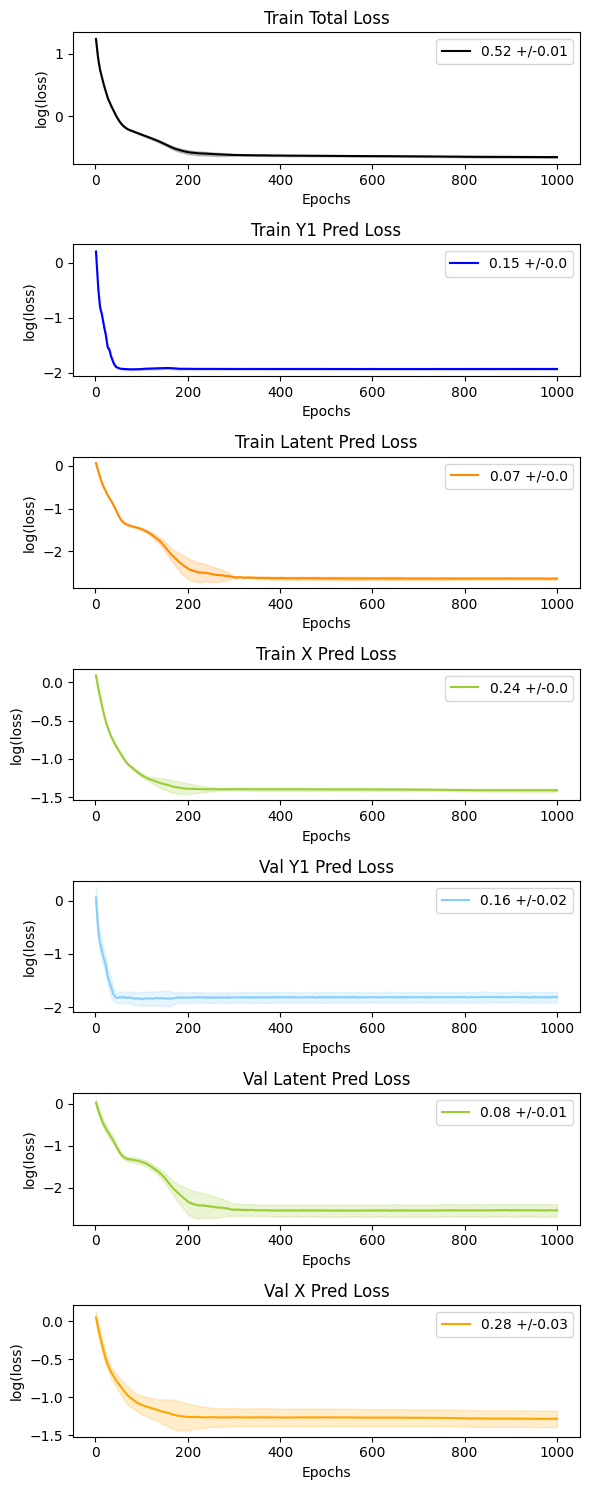

In [32]:
num_latents = len(latent_col_names)
epochs = np.arange(1, num_epochs + 1)
# Plot mean and standard deviation of losses
train_mean_total_pred_loss = np.mean(np.log(np.array(train_total_pred_loss_per_epoch_per_seed)), axis=0)
train_std_total_pred_loss = np.std(np.log(np.array(train_total_pred_loss_per_epoch_per_seed)), axis=0)

train_mean_y1_pred_loss = np.mean(np.log(np.array(train_y1_pred_loss_per_epoch_per_seed)), axis=0)
train_std_y1_pred_loss = np.std(np.log(np.array(train_y1_pred_loss_per_epoch_per_seed)), axis=0)

train_mean_latent_pred_loss = np.mean(np.log(np.array(train_latent_pred_loss_per_epoch_per_seed)), axis=0)
train_std_latent_pred_loss = np.std(np.log(np.array(train_latent_pred_loss_per_epoch_per_seed)), axis=0)

train_mean_x_pred_loss = np.mean(np.log(np.array(train_x_pred_loss_per_epoch_per_seed)), axis=0)
train_std_x_pred_loss = np.std(np.log(np.array(train_x_pred_loss_per_epoch_per_seed)), axis=0)

val_mean_y1_pred_loss = np.mean(np.log(np.array(val_y1_pred_loss_per_epoch_per_seed)), axis=0)
val_std_y1_pred_loss = np.std(np.log(np.array(val_y1_pred_loss_per_epoch_per_seed)), axis=0)

val_mean_latent_pred_loss = np.mean(np.log(np.array(val_latent_pred_loss_per_epoch_per_seed)), axis=0)
val_std_latent_pred_loss = np.std(np.log(np.array(val_latent_pred_loss_per_epoch_per_seed)), axis=0)

val_mean_x_pred_loss = np.mean(np.log(np.array(val_x_pred_loss_per_epoch_per_seed)), axis=0)
val_std_x_pred_loss = np.std(np.log(np.array(val_x_pred_loss_per_epoch_per_seed)), axis=0)

# Plotting
plt.figure(figsize=(6, 15))
plt.subplot(7, 1, 1)
plt.plot(epochs, train_mean_total_pred_loss, 
         label=f'{round(np.mean(np.array(train_total_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_total_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
        color='black')
plt.fill_between(epochs, train_mean_total_pred_loss - train_std_total_pred_loss, train_mean_total_pred_loss + train_std_total_pred_loss, color='black', alpha=0.2)
plt.title('Train Total Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(7, 1, 2)
plt.plot(epochs, train_mean_y1_pred_loss, 
         label=f'{round(np.mean(np.array(train_y1_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_y1_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='blue')
plt.fill_between(epochs, train_mean_y1_pred_loss - train_std_y1_pred_loss, train_mean_y1_pred_loss + train_std_y1_pred_loss, color='blue', alpha=0.2)
plt.title('Train Y1 Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()
      
plt.subplot(7, 1, 3)
plt.plot(epochs, train_mean_latent_pred_loss, 
         label=f'{round(np.mean(np.array(train_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='darkorange')
plt.fill_between(epochs, train_mean_latent_pred_loss - train_std_latent_pred_loss, train_mean_latent_pred_loss + train_std_latent_pred_loss, color='darkorange', alpha=0.2)
plt.title('Train Latent Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(7, 1, 4)
plt.plot(epochs, train_mean_x_pred_loss,
            label=f'{round(np.mean(np.array(train_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
                  f'{round(np.std(np.array(train_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='yellowgreen')
plt.fill_between(epochs, train_mean_x_pred_loss - train_std_x_pred_loss, train_mean_x_pred_loss + train_std_x_pred_loss, color='yellowgreen', alpha=0.2)
plt.title('Train X Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(7, 1, 5)
plt.plot(epochs, val_mean_y1_pred_loss,
         label=f'{round(np.mean(np.array(val_y1_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(val_y1_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='lightskyblue')
plt.fill_between(epochs, val_mean_y1_pred_loss - val_std_y1_pred_loss, val_mean_y1_pred_loss + val_std_y1_pred_loss, color='lightskyblue', alpha=0.2)
plt.title('Val Y1 Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(7, 1, 6)
plt.plot(epochs, val_mean_latent_pred_loss,
         label=f'{round(np.mean(np.array(val_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(val_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='yellowgreen')
plt.fill_between(epochs, val_mean_latent_pred_loss - val_std_latent_pred_loss, val_mean_latent_pred_loss + val_std_latent_pred_loss, color='yellowgreen', alpha=0.2)
plt.title('Val Latent Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(7, 1, 7)
plt.plot(epochs, val_mean_x_pred_loss, 
         label=f'{round(np.mean(np.array(val_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(val_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='orange')
plt.fill_between(epochs, val_mean_x_pred_loss - val_std_x_pred_loss, val_mean_x_pred_loss + val_std_x_pred_loss, color='orange', alpha=0.2)
plt.title('Val X Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.tight_layout()

#### Model feature importance analysis

In [ ]:
dataset_df = pd.DataFrame(dataset[:, :len(descriptors + latent_col_names)], columns=descriptors + latent_col_names)
train_dataset = dataset[train_idxs[fold_num]]
val_dataset = dataset[val_idxs[fold_num]]
train_dataset_df = pd.DataFrame(train_dataset[:, :len(descriptors + latent_col_names)], columns=descriptors + latent_col_names)
val_dataset_df = pd.DataFrame(val_dataset[:, :len(descriptors + latent_col_names)], columns=descriptors + latent_col_names)

def convert_to_tensor(obs):
    obs_tensor = torch.from_numpy(obs.values).to(dtype=torch.float32)
    loaded_ae.eval()
    with torch.no_grad():
        ae_out = loaded_ae(obs_tensor)
    # return ae_out['z'][:, 1]
    return ae_out['y1_pred']

explainer = Exact(convert_to_tensor, val_dataset_df)
shapley_values = explainer(val_dataset_df)

shap.plots.bar(shapley_values, max_display=15)

# Save the shapley values to csv
shapley_values_df = pd.DataFrame(shapley_values.values, columns=val_dataset_df.columns)
shapley_values_df.to_csv(f'shapley_vals_for_y_pred_using_fold{fold_num}_val.csv', index=False)

### Bayesian optimization

In [ ]:
class ExactGPModel(ExactGP, GPyTorchModel):
    _num_outputs = 1
    MIN_INFERRED_NOISE_LEVEL = 1e-5

    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        if kernel == 'RBF':
            self.covar_module = ScaleKernel(RBFKernel())
        elif kernel == 'Matern':
            self.covar_module = ScaleKernel(MaternKernel(nu=2.5))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
    
def train_model(train_x, train_y, epochs, lr):
    likelihood = GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, 'Matern')

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = ExactMarginalLogLikelihood(likelihood, model)
    for i in range(epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    return model, likelihood

def optimize_acq_fn_and_get_observation(acq_fn, x_test, y_test):
    candidates, _ = optimize_acqf_discrete(
        acq_function=acq_fn,
        choices=x_test, # IMP : Restricts the space from which to select the next candidate 
        q=1, # Number of candidates to select
        max_batch_size=2048,  
        num_restarts=10, # Number of random restarts for optimizer
        raw_samples=512, # Number of random samples for initialization for optimizer
        options={"batch_limit": 5, "maxiter": 200},
        unique=True # Whether to return only unique candidates
    )

    # observe new values. In this case just retreieve 1 value
    x_new = candidates.detach()
    # Find index where it matches in x_test
    match_idx = (x_test == x_new).all(dim = 1)
    # Find where it matches in y_test
    y_new = y_test[match_idx]

    # Remove from the candidate from the test
    x_test = x_test[~match_idx]
    y_test = y_test[~match_idx]

    return x_new, y_new, match_idx, x_test, y_test

In [ ]:
####################################################################################
# Code adopted from PAL2 acquition_function_bo.ipynb. MAKE SURE TO ACK AND CITE !!!
####################################################################################

# First load the model and get the latents and their predictions
x_torch_all = torch.from_numpy(dataset[:, 0:(len(descriptors + latent_col_names))]).to(dtype=torch.float32)
# Using the true values for prediction
y_true = torch.from_numpy(dataset[:, len(descriptors + latent_col_names)]).to(dtype=torch.float32)

# Check for nan in dataset
if np.isnan(x_torch_all).any():
    print('Dataset has NaN values. Please check.')
else:
    print('Dataset has no NaN values.')

maximize = True
verbose = True
bo_n_trials = 200
bo_n_updates = 10
# initial_num_samples_to_train_GP = 2
# test_size = 1 -  initial_num_samples_to_train_GP/y_true.shape[0]
test_size = 0.9
print(f'test size = {test_size}')
# bo_n_batches = math.floor(test_size * y_true.shape[0])
bo_n_batches = 100
print(f'bo_n_batches = {bo_n_batches}')
epochs_train_GP = 100
lr_GP = 0.1
save_file_loc = 'bo_results.csv'

# loaded_ae.eval()
# with torch.no_grad():
#     ae_out = loaded_ae(x_torch_all)
# latents = ae_out['z']

latents = x_torch_all

# Sanity check : Identify row indices where the latent values are the same in latents
duplicate_latent_indices = []
for i in range(latents.shape[0]):
    for j in range(i + 1, latents.shape[0]):
        if torch.equal(latents[i], latents[j]):
            duplicate_latent_indices.append((i, j))
if len(duplicate_latent_indices) > 0:
    print(f'Found duplicate latent representations at indices: {duplicate_latent_indices}')
    raise ValueError("Duplicate latent representations found.")

best_obs_val_hist = []
selected_latent_hist = []
selected_obs_hist = []
for trial_num in range(1, bo_n_trials + 1):
    t0 = time.monotonic()

    print(f' ----- Trial {trial_num} ----- ')
    latents_train, latents_test, y_train, y_test = train_test_split(latents, y_true, 
                                                                    test_size=test_size,
                                                                    random_state=trial_num)
    print(f'Train size: {latents_train.shape[0]}, Test size: {latents_test.shape[0]}')

    # latents_train_means = torch.mean(latents_train, axis=0)
    # latents_train_stddev = torch.std(latents_train, axis=0)
    # latents_train_stand = (latents_train - latents_train_means)/latents_train_stddev

    # latents_test_means = torch.mean(latents_test, axis=0)
    # latents_test_stddev = torch.std(latents_test, axis=0)
    # latents_test_stand = (latents_test - latents_test_means)/latents_test_stddev

    latents_train_stand = latents_train
    latents_test_stand = latents_test

    # check for max in preds
    if maximize : 
        best_obs_val = y_train.max()
        best_obs_val_idx = y_train.argmax()
        optimal_soln = torch.cat([y_train, y_test]).max()
    else:
        best_obs_val = y_train.min()
        best_obs_val_idx = y_train.argmin()
        optimal_soln = torch.cat([y_train, y_test]).min()

    if best_obs_val.eq(optimal_soln):
        if maximize:
            print(f'Max in training set. Removing it. Max value is {optimal_soln}')
        else:
            print(f'Min in training set. Removing it. Min value is {optimal_soln}')
        # removing from train and adding to test
        latents_test_stand = torch.cat([latents_test_stand, latents_train_stand[best_obs_val_idx, :].unsqueeze(0)], dim=0)
        latents_train_stand = torch.cat([latents_train_stand[0:best_obs_val_idx, :], latents_train_stand[best_obs_val_idx + 1:, :]], dim=0)
        y_test = torch.cat([y_test, y_train[best_obs_val_idx].unsqueeze(0)], dim=0)
        y_train = torch.cat([y_train[0:best_obs_val_idx], y_train[best_obs_val_idx + 1:]], dim=0)
        if maximize:
            # Upadting best obs value
            print('Updating best observed value')
            best_obs_val = y_train.max()
        else:
            best_obs_val = y_train.min()

    best_obs_val_batch = []
    selected_latent_batch = []
    selected_obs_batch = []
    best_obs_val_batch.append(best_obs_val)

    likelihood = GaussianLikelihood()
    model = ExactGPModel(latents_train_stand, y_train.squeeze(), likelihood, 'Matern')
    acq_fn = ExpectedImprovement(model=model, best_f=best_obs_val_batch[-1], maximize=maximize)

    for batch_num in range(1, bo_n_batches + 1):
        # Train the model on the initial training data. Then update it with points chosen by the acq. fn from the test set
        if (batch_num - 1)%bo_n_updates == 0:
            print(f'Updating the model.')
            model, likelihood = train_model(latents_train_stand, y_train, epochs_train_GP, lr_GP)

        # Here we get the new latent, new observation and the updated latent and observation test sets with that latent and obs removed.
        latent_new, y_new, match_idx, latents_test_stand, y_test = optimize_acq_fn_and_get_observation(acq_fn, latents_test_stand, y_test)
        
        # Add the latent and observation to training set.
        latents_train_stand = torch.cat([latents_train_stand, latent_new], dim=0)
        y_train = torch.cat([y_train, y_new], dim=0)

        # Track the latent and corresponding obs
        selected_latent_batch.append(latent_new)
        selected_obs_batch.append(y_new)

        if maximize:
            best_obs_val_batch.append(y_train.max())
        else:
            best_obs_val_batch.append(y_train.min())

        # Define acquisition function with updated GP model and best observed obs so far.
        acq_fn = ExpectedImprovement(model=model, best_f=best_obs_val_batch[-1], maximize=maximize)

        if verbose:
            print(f'Batch {batch_num}, best obs val {best_obs_val_batch[-1]}')
    
    t1 = time.monotonic()
    print(f' Time = {round(t1 - t0, 3)}')
    best_obs_val_hist.append(best_obs_val_batch)
    selected_latent_hist.append(selected_latent_batch)
    selected_obs_hist.append(selected_obs_batch)

In [ ]:
# overlay the 100 trials in line plot with varying shades of blue
plt.figure(figsize=(8, 6))
for i in range(len(best_obs_val_hist)):
    plt.plot(range(1, len(best_obs_val_hist[i]) + 1), best_obs_val_hist[i], color='blue', alpha=0.1)
    # Mark the initial best observed value
    plt.scatter(1, best_obs_val_hist[i][0], color='red', s=10)

best_obs_val_hist_arr = np.array(best_obs_val_hist)
print(np.mean(best_obs_val_hist_arr, axis=0).shape)
plt.plot(range(1, len(best_obs_val_hist_arr[0]) + 1), np.mean(best_obs_val_hist_arr, axis=0), color='orange', label='Mean of 200 trials', linewidth=2)
plt.legend()

# for i in range(len(selected_obs_hist)):
#     selected_obs_concat = torch.cat(selected_obs_hist[i]).numpy()
#     plt.scatter(range(1, len(selected_obs_concat) + 1), selected_obs_concat, color='blue', s=10, alpha=0.1)
plt.xlabel('Number of evaluated design candidates', fontsize=14)
plt.ylabel('Best Observed Value', fontsize=14)
plt.grid()

In [ ]:
print(len(best_obs_val_hist))

In [ ]:
# Do UMAP of the 100 selected latents for the first trial
selected_latents_trial_1 = torch.cat(selected_latent_hist[0], dim=0)
reducer = umap.UMAP(n_components=2, random_state=random_state)
embedded_selected_latents = reducer.fit_transform(selected_latents_trial_1)
plt.figure(figsize=(8, 6))
plt.scatter(embedded_selected_latents[:, 0], embedded_selected_latents[:, 1], c=range(1, embedded_selected_latents.shape[0] + 1), cmap='viridis' , s=1)
# Overlay the starting point in red
plt.scatter(embedded_selected_latents[0, 0], embedded_selected_latents[0, 1], color='red', s=50, label='Starting Point')
# Overlay with selected obs hist values as size of the point
selected_obs_concat = torch.cat(selected_obs_hist[0]).numpy()
# Normalize the sizes for better visualization
sizes = 100 * (selected_obs_concat - selected_obs_concat.min()) / (selected_obs_concat.max() - selected_obs_concat.min() + 1e-6) + 10   
plt.scatter(embedded_selected_latents[:, 0], embedded_selected_latents[:, 1], s=sizes, edgecolors='black', facecolors='none', label='Selected Points (size ~ obs value)')
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Selection Order')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP of Selected Latents in Trial 1')
plt.show()

In [ ]:
total_number_of_materials_in_dataset = 244
# Store the hist of best obs val in a numpy array. 
best_obs_val_df = pd.DataFrame()
# Store the index of max val in each trial in a list
batches_to_reach_optimal = []
for trial in range(1, bo_n_trials + 1):
    best_obs_val_df[f'trial{trial}'] = np.array(best_obs_val_hist[trial - 1])
    if maximize:
        batches_to_reach_optimal.append((best_obs_val_df[f'trial{trial}'].argmax() + 1)/total_number_of_materials_in_dataset*100)
    else:
        batches_to_reach_optimal.append((best_obs_val_df[f'trial{trial}'].argmin() + 1)/total_number_of_materials_in_dataset*100)
best_obs_val_df.to_csv(save_file_loc, index=False)
    
# Plot box plot and strip plot of iter_to_reach_max
batches_to_reach_optimal_df = pd.DataFrame(batches_to_reach_optimal, columns=['value'])
batches_to_reach_optimal_df['method'] = 'NestedAE'
batches_to_reach_optimal_df.to_csv('data.csv', index=False)

# fig, ax = plt.subplots(1,1)
# ax = sns.boxplot(x='method', y='value', data=batches_to_reach_optimal_df, 
#                 showfliers=False, width=0.5,
#                 medianprops=dict(color='white', linewidth=0))
# # This is to display the dots 
# ax = sns.stripplot(x='method', y='value', data=batches_to_reach_optimal_df, hue='method', legend=False,
#                    alpha=.4, linewidth=1, jitter=0)

# mean_val = batches_to_reach_optimal_df['value'].mean()
# median_val = batches_to_reach_optimal_df['value'].median()
# ax.text(-0.4, mean_val + 0.1, f"Mean: {mean_val:.1f}", ha='center', fontsize=8, color='black', fontweight='bold')
# ax.text(-0.4, median_val + 0.1, f"Median: {median_val:.1f}", ha='center', fontsize=8, color='black', fontweight='bold')
# # Show mean as a horizontal dotted red line
# ax.axhline(mean_val, color='red', linestyle='--', linewidth=2, label='Mean')
# # Show median as a horizontal dotted black line
# ax.axhline(median_val, color='black', linestyle='--', linewidth=2, label='Median')

# plt.gcf().set_size_inches((6,6))
# plt.gca().set_xlabel('')
# plt.gca().set_ylabel('% space explored', fontsize=20)
# plt.tight_layout()
# fig.patch.set_facecolor('white')

### Exploring the trajectory taken in the latent space

In [ ]:
chosen_trial_num = 0
# Get the latents and the observations
chosen_latents = np.array(selected_latent_hist[chosen_trial_num]).squeeze()
chosen_obs_vals = selected_obs_hist[chosen_trial_num]

if maximize:
    # Find the indices of max value in the list
    max_idx = chosen_obs_vals.index(max(chosen_obs_vals))
else:
    min_idx = chosen_obs_vals.index(min(chosen_obs_vals))

# UMAP of chosen latents
reducer = umap.UMAP(n_components=2, random_state=random_state)
embedded_dataset = reducer.fit_transform(chosen_latents)

# Plot UMAP
plt.figure(figsize=(4, 4))
plt.scatter(embedded_dataset[:, 0], embedded_dataset[:, 1], c=chosen_obs_vals, cmap='Spectral', s=1)
plt.colorbar(label='Observation Value')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
# Fix the axis limits 
plt.xlim(embedded_dataset[:, 0].min() - 1, embedded_dataset[:, 0].max() + 1)
plt.ylim(embedded_dataset[:, 1].min() - 1, embedded_dataset[:, 1].max() + 1)
plt.show()

plt.figure(figsize=(4, 4))
# Color the latents uptil the max_idx or min_idx as black
if maximize:
    ax = plt.scatter(embedded_dataset[:max_idx, 0], embedded_dataset[:max_idx, 1], c=range(max_idx), s=1, label=range(max_idx), cmap='Greys')
    # Color the starting latent as green and ending latent as red
    plt.scatter(embedded_dataset[0, 0], embedded_dataset[0, 1], c='green', s=3, label='Start')
    plt.scatter(embedded_dataset[max_idx, 0], embedded_dataset[max_idx, 1], c='red', s=3, label='End')
else:
    ax = plt.scatter(embedded_dataset[:min_idx, 0], embedded_dataset[:min_idx, 1], c=range(min_idx), s=1, label=range(min_idx), cmap='Greys')
    # Color the starting latent as green and ending latent as red
    plt.scatter(embedded_dataset[0, 0], embedded_dataset[0, 1], c='green', s=3, label='Start')
    plt.scatter(embedded_dataset[min_idx, 0], embedded_dataset[min_idx, 1], c='red', s=3, label='End')

# Insert color bar
plt.colorbar(ax, label='Sampling order')
plt.legend()
# Fix the axis limits 
plt.xlim(embedded_dataset[:, 0].min() - 1, embedded_dataset[:, 0].max() + 1)
plt.ylim(embedded_dataset[:, 1].min() - 1, embedded_dataset[:, 1].max() + 1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')


### Decode the latents to find the design conditions

In [ ]:
# Get the last 4 latents before the max/min obs value
choose_idx = 23
if maximize:
    last_latents = chosen_latents[max_idx+choose_idx:max_idx+choose_idx+1]
else:
    last_latents = chosen_latents[min_idx-5:min_idx-4]

# Decode the latents using AE1 decoder
loaded_ae.eval()
inp = torch.from_numpy(last_latents).to(dtype=torch.float32)
with torch.no_grad():
    for i, layer in enumerate(loaded_ae.ae_modules['latents_predictor']):
        if i == 0:
            out1_ae2 = layer(inp)
        else:
            out1_ae2 = layer(out1_ae2)

with torch.no_grad():
    for i, layer in enumerate(loaded_ae.ae_modules['solvent_predictor']):
        if i == 0:
            out2_ae2 = layer(inp)
        else:
            out2_ae2 = layer(out2_ae2)

print("Solvent Categories : 'DMSO', 'THTO', 'DMF', 'NMP', 'ACETONE', 'METHA', 'GBL', 'NITRO'")
print(torch.round(torch.softmax(out2_ae2, dim=1), decimals=3))
print(chosen_obs_vals[max_idx+choose_idx:max_idx+choose_idx+1])

### Loading AE1 to get the deisgn conditions for the perovskite

In [ ]:
fold_num = 5
saved_module_name = 'AE1'
latent_dim = 9
module_params = {'name':'AE1', 
                    'modules':{

                        'encoder':{
                            'input_dim':15,
                            'output_dim':latent_dim, 
                            'hidden_dim':25, 
                            'hidden_layers':1, 
                            'hidden_activation':None, 
                            'output_activation':None, 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        'bandgaps_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':1,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':torch.nn.ReLU(),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        'A_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':5,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':None,
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                        'B_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':6,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':None,
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                        'X_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':3,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':None,
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        }

                    }}

loaded_state_dict = f'runs/nestedae_{saved_module_name}_bandgaps_THEN_perov_solv_BE/nestedae_fold{fold_num}'
loaded_ae2 = AE(module_params)
loaded_ae2.load_state_dict(torch.load(loaded_state_dict))
loaded_ae2.eval()

In [ ]:
inp = out1_ae2
with torch.no_grad():
    for i, layer in enumerate(loaded_ae2.ae_modules['A_predictor']):
        if i == 0:
            out1_ae1 = layer(inp)
        else:
            out1_ae1 = layer(out1_ae1)

with torch.no_grad():
    for i, layer in enumerate(loaded_ae2.ae_modules['B_predictor']):
        if i == 0:
            out2_ae1 = layer(inp)
        else:
            out2_ae1 = layer(out2_ae1)

with torch.no_grad():
    for i, layer in enumerate(loaded_ae2.ae_modules['X_predictor']):
        if i == 0:
            out3_ae1 = layer(inp)
        else:
            out3_ae1 = layer(out3_ae1)

print("A site Categories : 'K', 'Rb', 'Cs', 'MA', 'FA'")
print(torch.round(torch.softmax(out1_ae1, dim=1), decimals=3))
print("B site Categories : 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb'")
print(torch.round(torch.softmax(out2_ae1, dim=1), decimals=3))
print("X site Categories : 'Cl', 'Br', 'I'")
print(torch.round(torch.softmax(out3_ae1, dim=1), decimals=3))